# Imports / Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
from datetime import datetime
from functools import reduce
from operator import itemgetter
import os
import pickle
import pprint
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import configs
from content_corpus import ContentCorpus

pp = pprint.PrettyPrinter()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Load recent content corpus

In [3]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16.9 µs


In [4]:
%%time
recent_content_corpus.load_recent_content(df=pd.read_csv('../data/recent_content_corpus.csv', index_col=0),
                                          days_of_recent_content=2)
recent_content_corpus.df['meta_keywords'] = recent_content_corpus.df['meta_keywords'].apply(lambda x: x if type(x)== type('this') else '')
#recent_content_corpus.load_recent_content(days_of_recent_content=2)

CPU times: user 1.34 s, sys: 236 ms, total: 1.58 s
Wall time: 2.18 s


In [ ]:
#recent_content_corpus.df.to_csv('../data/recent_content_corpus.csv')

In [5]:
len(recent_content_corpus.df)

48293

In [6]:
sum(recent_content_corpus.df.title.apply(lambda x: len(x) > 0))

48293

In [7]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 1min 56s, sys: 12.9 s, total: 2min 9s
Wall time: 1min 16s


In [8]:
%%time
recent_content_corpus.categorize_content()


 svm classifier performance
 accuracy:   0.884
 classification report: 
                                precision    recall  f1-score   support

          Entertainment & Arts       0.92      0.97      0.94        62
            Finance & Business       0.87      0.93      0.90       134
                Gear & Gadgets       0.67      0.67      0.67         3
            Lifestyle & Health       0.90      0.75      0.82        36
  Politics, Policy & Economics       0.92      0.82      0.87        60
Technology, Science & Medicine       0.79      0.83      0.81        76
                 Travel & Food       1.00      0.57      0.73         7
                   U.S. Sports       0.97      1.00      0.98        29
                  World Sports       1.00      0.94      0.97        16

                   avg / total       0.89      0.88      0.88       423

 confusion matrix: 
[[ 60   1   0   0   0   1   0   0   0]
 [  0 125   1   0   0   8   0   0   0]
 [  0   0   2   0   0   1   0   0 

In [9]:
a = recent_content_corpus.texts_tfidf_matrix
print((a.data.nbytes + a.indptr.nbytes + a.indices.nbytes)/1e6)

103.519776


# Determine parts of speech for texts vocab

In [10]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load('en_core_web_lg')

class WhitespaceTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(' ')
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [11]:
def vocab_to_pos(vocab):
    n = len(vocab)
    batch_size = 10000
    pos = []
    
    for start_idx in np.arange(0, n, batch_size):
        end_idx = min(start_idx + batch_size, n)
        vocab_str = ' '.join(vocab[start_idx:end_idx])
        pos += [spacy_token.pos_ for spacy_token in nlp(vocab_str)]
        
    return pos

In [12]:
%%time
texts_tfidf_pos = vocab_to_pos(recent_content_corpus.texts_tfidf_vocab)

CPU times: user 1min 4s, sys: 12.6 s, total: 1min 17s
Wall time: 24 s


In [13]:
texts_tfidf_pos = np.array(texts_tfidf_pos)

texts_nouns_idxs = np.where([pos in ['NOUN', 'PROPN'] for pos in texts_tfidf_pos])[0]
texts_nouns_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[:, texts_nouns_idxs]

texts_adjs_idxs = np.where(texts_tfidf_pos == 'ADJ')[0]
texts_adjs_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[:, texts_adjs_idxs]

# Create dense vectors

In [14]:
titles_dense_matrix = recent_content_corpus.titles_dense_matrix

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


In [16]:
texts_dense_matrix = recent_content_corpus.texts_dense_matrix

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


# Make topic cluster classifier

## Sample some article pairs

In [ ]:
def sample_article_pairs(df, n, extra_fields=None):
    fields = ['_id']
    if extra_fields:
        fields += extra_fields
    
    first_articles = df[fields].sample(n, replace=True).reset_index()
    first_articles.columns = [colname + '_0' for colname in first_articles.columns]
    second_articles = df[fields].sample(n, replace=True).reset_index()
    second_articles.columns = [colname + '_1' for colname in second_articles.columns]
    
    article_pairs = pd.concat([first_articles, second_articles], axis=1)
    
    return article_pairs
    

In [ ]:
subset = recent_content_corpus.df.copy()

In [ ]:
topic_cluster_training_article_pairs = sample_article_pairs(subset, 250000, extra_fields=['title'])

In [ ]:
topic_cluster_training_article_pairs.head()

## Calculate metrics for sampled pairs

In [17]:
from scipy.spatial.distance import cosine

In [18]:
def selected_article_pairs_metrics(df):
    title_dists = np.zeros(len(df))
    text_dists = np.zeros(len(df))
    text_nouns_dists = np.zeros(len(df))
    text_adjs_dists = np.zeros(len(df))
    title_dense_dists = np.zeros(len(df))
    text_dense_dists = np.zeros(len(df))

    for idx, row in df.iterrows():
        article_1_idx = row['index_0']
        article_2_idx = row['index_1']

        title_dist, text_dist, text_nouns_dist, text_adjs_dist = (
            article_pair_metrics(article_1_idx, article_2_idx)
        )
        
        title_dense_dist = np.round(cosine(
            titles_dense_matrix[article_1_idx],
            titles_dense_matrix[article_2_idx]
        ), 4)
        
        text_dense_dist = np.round(cosine(
            texts_dense_matrix[article_1_idx],
            texts_dense_matrix[article_2_idx]
        ), 4)

        title_dists[idx] = title_dist
        text_dists[idx] = text_dist
        text_nouns_dists[idx] = text_nouns_dist
        text_adjs_dists[idx] = text_adjs_dist
        title_dense_dists[idx] = title_dense_dist
        text_dense_dists[idx] = text_dense_dist

    df['title_dist'] = title_dists
    df['text_dist'] = text_dists
    df['text_nouns_dist'] = text_nouns_dists
    df['text_adjs_dist'] = text_adjs_dists
    df['title_dense_dist'] = title_dense_dists
    df['text_dense_dist'] = text_dense_dists

    return df


def article_pair_metrics(article_1_idx, article_2_idx):
    title_dist = cosine_dist(
        recent_content_corpus.titles_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_dist = cosine_dist(
        recent_content_corpus.texts_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_nouns_dist = cosine_dist(
        texts_nouns_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_adjs_dist = cosine_dist(
        texts_adjs_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    return title_dist, text_dist, text_nouns_dist, text_adjs_dist


def cosine_dist(doc_term_matrix, doc_1_idx, doc_2_idx):
    doc_1_vector = doc_term_matrix[doc_1_idx].toarray()
    doc_2_vector = doc_term_matrix[doc_2_idx].toarray()    
    cosine_dist = np.round(cosine(doc_1_vector, doc_2_vector), 4)
    return cosine_dist

In [ ]:
%%time
topic_cluster_training_article_pairs = selected_article_pairs_metrics(topic_cluster_training_article_pairs)

In [ ]:
topic_cluster_training_article_pairs.head()

In [ ]:
topic_cluster_training_article_pairs[:50000].to_csv('topic_cluster_training_article_pairs_250k.csv')

In [ ]:
topic_cluster_training_article_pairs[50000:100000].to_csv('topic_cluster_training_article_pairs_250k_2.csv')

In [ ]:
topic_cluster_training_article_pairs[100000:150000].to_csv('topic_cluster_training_article_pairs_250k_3.csv')

In [ ]:
topic_cluster_training_article_pairs[150000:200000].to_csv('topic_cluster_training_article_pairs_250k_4.csv')

In [ ]:
topic_cluster_training_article_pairs[200000:250000].to_csv('topic_cluster_training_article_pairs_250k_5.csv')

## Label the sampled pairs

[ done manually ]

## Ingest the labeled pairs

In [ ]:
labeled_tc_pairs = pd.read_csv('../data/labeled_topic_cluster_training_article_pairs_250k_1.csv', index_col=0)

In [ ]:
for i in range(2, 5):
    filestr = ('../data/labeled_topic_cluster_training_article_pairs_250k_%s.csv' % (i))
    labeled_tc_pairs = labeled_tc_pairs.append(pd.read_csv(filestr, index_col=0))

In [ ]:
%%time
# always use the freshest metrics
labeled_tc_pairs = selected_article_pairs_metrics(labeled_tc_pairs) 

In [ ]:
labeled_tc_pairs.shape

## Fit classifier

In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
features = ['title_dist', 'text_dist', 'text_nouns_dist', 'text_adjs_dist', 
            'title_dense_dist', 'text_dense_dist']

In [ ]:
for feature in features:
    labeled_tc_pairs[feature] = (
        labeled_tc_pairs[feature].apply(lambda x: 1 if np.isnan(x) else x)
    )

In [ ]:
sgds = []
precisions = []
recalls = []
f1s = []
for i in tqdm_notebook(np.arange(100)):
    X = labeled_tc_pairs[features]
    y = labeled_tc_pairs['same_topic_cluster']

    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.5)
    )

    sgd = SGDClassifier(
        loss='modified_huber',
        max_iter=100,
        n_jobs=2,
        learning_rate='optimal',
        penalty='l2',
        alpha=0.0001,
        l1_ratio=0.15
    )
    sgd.fit(X_train, y_train)

    pred = sgd.predict(X_test)
    
    sgds += [sgd]
    precision = metrics.precision_score(y_test, pred)
    precisions += [precision]
    recall = metrics.recall_score(y_test, pred)
    recalls += [metrics.recall_score(y_test, pred)]
    f1 = 2 * precision * recall / (precision + recall)
    f1s += [f1]
    
print('Mean precision: %s' % str(np.mean(precisions)))
plt.hist(precisions)
plt.show()
print('Mean recall: %s' % str(np.mean(recalls)))
plt.hist(recalls)
plt.show()

In [ ]:
f1_max_arg = np.argmax(f1s)

In [ ]:
precisions[f1_max_arg]

In [ ]:
recalls[f1_max_arg]

In [ ]:
# tcc = sgds[f1_max_arg]
# with open('../models/topic_cluster_classifier.pkl', 'wb') as output:
#     pickle.dump(tcc, output, pickle.HIGHEST_PROTOCOL)

In [21]:
with open('../models/topic_cluster_classifier.pkl', 'rb') as input:
    tcc = pickle.load(input)

In [22]:
tcc.coef_

array([[-1.55829429, -1.9288785 , -1.75743004, -1.10949438, -0.38484585,
        -0.26861498]])

In [ ]:
labeled_tc_pairs['same_topic_cluster_predicted'] = (
    tcc.predict(X)
)
labeled_tc_pairs['same_topic_cluster_probability'] = (
    tcc.predict_proba(X)[:, 1]
)

In [ ]:
for idx, row in labeled_tc_pairs[
    ((labeled_tc_pairs.same_topic_cluster == 0)
     & (labeled_tc_pairs.same_topic_cluster_predicted == 1))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

In [ ]:
for idx, row in labeled_tc_pairs[
    ((labeled_tc_pairs.same_topic_cluster == 1)
     & (labeled_tc_pairs.same_topic_cluster_predicted == 0))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

# Supervised topic clustering

## Generate same_topic_cluster_probs graph

In [23]:
from scipy.sparse import csr_matrix, lil_matrix, dok_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.sparsetools import connected_components

from clustering import agglomeratively_cluster_dist_matrix, gen_clusters

In [24]:
def get_same_topic_cluster_probs(subset, pairs_dists_max_memory_use_mb=500):
    n_articles = len(subset)
    subset_indices = subset.index.values
    
    same_topic_cluster_probs = lil_matrix((n_articles, n_articles))
    num_dist_matrices = 6
    per_dist_matrix_max_memory = pairs_dists_max_memory_use_mb / num_dist_matrices / 2
    cols_batch = int(min(n_articles, per_dist_matrix_max_memory/8e-6))
    rows_batch = int(min(n_articles, per_dist_matrix_max_memory/(cols_batch * 8e-6)))

    # slice first articles
    for start_row in np.arange(0, n_articles, rows_batch):
        end_row = min(start_row+rows_batch, n_articles)

        # get first articles' vectors
        first_article_indices = subset_indices[start_row:end_row]
        first_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[first_article_indices]
        first_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[first_article_indices]
        first_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[first_article_indices]
        first_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[first_article_indices]
        first_titles_dense_matrix = titles_dense_matrix[first_article_indices]
        first_texts_dense_matrix = texts_dense_matrix[first_article_indices]

        # slice second articles
        for start_col in np.arange(start_row, n_articles, cols_batch):
            end_col = min(start_col+cols_batch, n_articles)

            # get second articles' vectors
            second_article_indices = subset_indices[start_col:end_col]    
            second_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[second_article_indices]
            second_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[second_article_indices]
            second_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[second_article_indices]
            second_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[second_article_indices]
            second_titles_dense_matrix = titles_dense_matrix[second_article_indices]
            second_texts_dense_matrix = texts_dense_matrix[second_article_indices]

            # create article pairs distance matrices
            titles_dists = 1-cosine_similarity(first_titles_tfidf_matrix, second_titles_tfidf_matrix)
            texts_dists = 1-cosine_similarity(first_texts_tfidf_matrix, second_texts_tfidf_matrix)
            nouns_dists = 1-cosine_similarity(first_nouns_tfidf_matrix, second_nouns_tfidf_matrix)
            adjs_dists = 1-cosine_similarity(first_adjs_tfidf_matrix, second_adjs_tfidf_matrix)
            titles_dense_dists = 1-cosine_similarity(first_titles_dense_matrix, second_titles_dense_matrix)
            texts_dense_dists = 1-cosine_similarity(first_texts_dense_matrix, second_texts_dense_matrix)
            
            # conserve memory
            del second_article_indices, second_titles_tfidf_matrix, second_texts_tfidf_matrix,\
                second_nouns_tfidf_matrix, second_adjs_tfidf_matrix, second_titles_dense_matrix,\
                second_texts_dense_matrix
            
            # combine article pairs distances
            pairs_metrics = pd.merge(
                subset[['const', 'n']][start_row:end_row], 
                subset[['const', 'n']][start_col:end_col], 
                on='const'
            )
            pairs_metrics['title_dist'] = titles_dists.reshape(-1)
            pairs_metrics['text_dist'] = texts_dists.reshape(-1)
            pairs_metrics['text_nouns_dist'] = nouns_dists.reshape(-1)
            pairs_metrics['text_adjs_dist'] = adjs_dists.reshape(-1)
            pairs_metrics['title_dense_dist'] = titles_dense_dists.reshape(-1)
            pairs_metrics['text_dense_dist'] = texts_dense_dists.reshape(-1)
            
            # conserve memory
            del titles_dists, texts_dists, nouns_dists, adjs_dists, titles_dense_dists,\
                texts_dense_dists

            # estimate p(same_cluster)
            pairs_metrics['same_topic_cluster_probability'] = (
                tcc.predict_proba(pairs_metrics[features])[:, 1]
            )
            
            pairs_metrics = pairs_metrics[
                pairs_metrics['same_topic_cluster_probability'] > 0
            ]
            
            for x, y, p in zip(pairs_metrics['n_x'],
                               pairs_metrics['n_y'],
                               pairs_metrics['same_topic_cluster_probability']):
                same_topic_cluster_probs[x, y] = same_topic_cluster_probs[y, x] = p
    
    return same_topic_cluster_probs

## Cluster same_topic_cluster_probs graph

In [25]:
subset = recent_content_corpus.df[
    ((recent_content_corpus.df.region_categorization_predicted == 'U.S. & Canada')
     & (recent_content_corpus.df.region_categorization_probability > 0.5)
     & (recent_content_corpus.df.topic_categorization_predicted == 'Politics, Policy & Economics')
     & (recent_content_corpus.df.topic_categorization_probability > 0.5))
]
subset.loc[:, 'const'] = np.zeros(len(subset))
subset.loc[:, 'n'] = np.arange(len(subset))
subset

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


_id           crawled_timestamp  \
36     5cfd62159cbe06151bb918b4  2019-06-09 19:46:29.743053   
38     5cfd62169cbe06151bb918b6  2019-06-09 19:46:30.584577   
39     5cfd62179cbe06151bb918b7  2019-06-09 19:46:31.570460   
63     5cfd624c9cbe061961a4cbd0  2019-06-09 19:47:23.723127   
64     5cfd624c9cbe061961a4cbd1  2019-06-09 19:47:24.702968   
65     5cfd62559cbe0619fbc2e4c6  2019-06-09 19:47:33.522036   
66     5cfd62569cbe061a084c5463  2019-06-09 19:47:34.313149   
67     5cfd62579cbe061a1937a760  2019-06-09 19:47:35.294281   
116    5cfd62e39cbe06203224b360  2019-06-09 19:49:54.781054   
124    5cfd63009cbe06221d870eb9  2019-06-09 19:50:24.352979   
137    5cfd63819cbe062a2ae6b8db  2019-06-09 19:52:33.087046   
150    5cfd64059cbe0630c5c8ec14  2019-06-09 19:54:45.030869   
151    5cfd64059cbe0630c5c8ec15  2019-06-09 19:54:45.628090   
171    5cfd64559cbe06357968b644  2019-06-09 19:56:04.785383   
172    5cfd64559cbe06357968b645  2019-06-09 19:56:05.655557   
174    5cfd64759cbe0637a84c4234  2019-06-09 19:56:36.966290   
219    5cfd64fb9cbe063e7a916b0b  2019-06-09 19:58:51.609518   
238    5cfd654d9cbe0642b20abb2b  2019-06-09 20:00:13.055795   
244    5cfd654f9cbe0642b20abb30  2019-06-09 20:00:15.192607   
249    5cfd65549cbe0641375ab288  2019-06-09 20:00:20.521745   
252    5cfd655e9cbe064327aab058  2019-06-09 20:00:30.184680   
260    5cfd65779cbe06436b77fa44  2019-06-09 20:00:55.058747   
262    5cfd65789cbe0643722b0b50  2019-06-09 20:00:56.158068   
271    5cfd657a9cbe0643722b0b55  2019-06-09 20:00:58.012461   
274    5cfd657a9cbe064375fd1031  2019-06-09 20:00:58.327090   
276    5cfd657a9cbe0643722b0b57  2019-06-09 20:00:58.570771   
282    5cfd659a9cbe06459a9c9eb6  2019-06-09 20:01:29.922015   
293    5cfd65ac9cbe0646c8ffb468  2019-06-09 20:01:48.102990   
301    5cfd65b69cbe064754f2f5c0  2019-06-09 20:01:58.091824   
303    5cfd65c59cbe0648c58e6320  2019-06-09 20:02:13.786360   
...                         ...                         ...   
48062  5cfffeb69cbe0636f83862ca  2019-06-11 19:19:17.584753   
48073  5cfffeb89cbe0636f83862d1  2019-06-11 19:19:20.657894   
48094  5cffff209cbe06395c49570a  2019-06-11 19:21:03.657851   
48143  5cffff6d9cbe063b9b5256e7  2019-06-11 19:22:21.601963   
48148  5cffff6f9cbe063b9b5256ec  2019-06-11 19:22:23.307576   
48150  5cffff6f9cbe063b9b5256ee  2019-06-11 19:22:23.835311   
48156  5cffff889cbe063cb505c559  2019-06-11 19:22:48.423094   
48158  5cffff899cbe063cb505c55b  2019-06-11 19:22:49.169187   
48161  5cffff899cbe063cb505c55e  2019-06-11 19:22:49.724980   
48179  5cffffc49cbe063f924dffc9  2019-06-11 19:23:47.957332   
48180  5cffffc59cbe063f85d856ff  2019-06-11 19:23:49.427271   
48181  5cffffc79cbe063fbfc9c575  2019-06-11 19:23:51.327693   
48182  5cffffc79cbe063fbfc9c576  2019-06-11 19:23:51.936547   
48183  5cffffc89cbe063fbfc9c577  2019-06-11 19:23:52.169418   
48201  5d0000409cbe0643595a01f2  2019-06-11 19:25:52.197928   
48202  5d0000429cbe0643a2f02320  2019-06-11 19:25:54.442264   
48205  5d00004d9cbe06444800435a  2019-06-11 19:26:05.049518   
48207  5d00004f9cbe06447e6bdc33  2019-06-11 19:26:07.371922   
48208  5d0000509cbe06447e6bdc34  2019-06-11 19:26:08.714043   
48209  5d0000529cbe06447e6bdc36  2019-06-11 19:26:10.754413   
48222  5d0000af9cbe0647fb0219fd  2019-06-11 19:27:42.596063   
48223  5d0000af9cbe0647fb0219fe  2019-06-11 19:27:43.783441   
48224  5d0000b29cbe064829318339  2019-06-11 19:27:46.423842   
48230  5d0000ca9cbe0648ea8ed314  2019-06-11 19:28:10.922193   
48262  5d0001679cbe064d82a04266  2019-06-11 19:30:46.666196   
48271  5d00016d9cbe064dbfa8a4cf  2019-06-11 19:30:53.394914   
48272  5d00016d9cbe064dbfa8a4d0  2019-06-11 19:30:53.817600   
48273  5d00016e9cbe064dbfa8a4d1  2019-06-11 19:30:54.251978   
48281  5d0001729cbe064de9b60919  2019-06-11 19:30:58.375754   
48287  5d0001769cbe064dfdfae728  2019-06-11 19:31:02.331747   

                                           meta_keywords  \
36                                                         
3

In [26]:
sys.getsizeof(subset)/1e6

27.252779

In [27]:
n_articles = len(subset)
print(n_articles)

3901


In [28]:
%%time
X = -get_same_topic_cluster_probs(subset).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

CPU times: user 20.8 s, sys: 2.35 s, total: 23.1 s
Wall time: 21.2 s


In [29]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

CPU times: user 11.6 s, sys: 434 ms, total: 12 s
Wall time: 12 s


In [30]:
ac_result.shape

(3174, 3)

In [31]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [32]:
ac_result_dec = ac_result[::-1] # easier to work with

In [33]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [34]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [35]:
n_clusters

727

In [36]:
subset.loc[:, 'topic_cluster_id'] = gen_clusters(ac_result, n_clusters)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
topic_cluster_id_counts = subset['topic_cluster_id'].value_counts()

In [38]:
(np.sum(topic_cluster_id_counts.values[topic_cluster_id_counts.values >= 20])
 /np.sum(topic_cluster_id_counts.values))

0.47423737503204305

In [39]:
topic_cluster_id_counts

7060    281
7045    196
7065    175
7069    153
7054     71
7056     64
7067     62
7023     54
7044     48
6462     44
7022     39
5710     37
6709     37
6672     33
6665     33
7020     32
6887     31
6565     29
6901     28
6815     28
7029     27
6971     25
6792     24
7008     23
6739     23
6992     23
6890     22
7059     22
7043     22
7010     21
       ... 
169       1
161       1
125       1
2162      1
3885      1
1838      1
1844      1
1860      1
1862      1
1874      1
1888      1
1900      1
1912      1
2638      1
1962      1
1974      1
1982      1
2028      1
2050      1
9         1
11        1
25        1
2094      1
63        1
71        1
2120      1
2144      1
109       1
111       1
2         1
Name: topic_cluster_id, Length: 727, dtype: int64

In [40]:
iterations = 0 
for idx, ct in zip(topic_cluster_id_counts.index, topic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset[
            subset['topic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




281 articles in cluster 7060
HEADLINE: Trump still hangs tariff threat over Mexico despite deal
HEADLINE: The Mexican ambassador to the US explains Trump’s claim of a new agricultural deal
HEADLINE: Mexico holds off Trump's fire but seen vulnerable to new pressure
HEADLINE: Mexico rejoices after averting Donald Trump’s tariffs threat
HEADLINE: Democratic presidential candidates hammer Trump over deal with Mexico
HEADLINE: Trump still hangs tariff threat over Mexico despite deal
HEADLINE: Trump Still Hangs Tariff Threat Over Mexico Despite Deal
HEADLINE: Democratic presidential candidates hammer Trump over deal with Mexico
HEADLINE: Trump still hangs tariff threat over Mexico despite deal
HEADLINE: Trump still hangs tariff threat over Mexico despite deal
HEADLINE: Trump defends migration deal, says tariff threat remains if Mexico falls short on pledges
HEADLINE: Mexico dodges bullet in migrant deal with US
HEADLINE: Trump says U.S. will release additional details on deal with Mexico 

HEADLINE: Trump urges appeals court to block subpoena for his accounting records
HEADLINE: Trump Urges Appeals Court to Block Subpoena for His Accounting Records
HEADLINE: Trump urges appeals court to block subpoena for his accounting records
HEADLINE: Trump urges appeals court to block subpoena for his accounting records
HEADLINE: Trump urges appeals court to block subpoena for his accounting records
HEADLINE: Trump urges appeals court to block subpoena for his accounting records
HEADLINE: Trump appeals to block subpoena for his accounting records
HEADLINE: Trump urges appeals court to block subpoena for his accounting records
HEADLINE: Trump appeals to block subpoena for his accounting records
HEADLINE: Trump appeals to block subpoena for his accounting records
HEADLINE: Donald Trump appeals to block subpoena for his accounting records
HEADLINE: Trump bets hard that the Supreme Court is just as corrupt as he is
HEADLINE: Trump Appeals Mazars Subpoena Ruling



14 articles in cluster 

## Cluster same_cluster_probs graph - LOAD TEST

In [166]:
subset = recent_content_corpus.df[
    ((recent_content_corpus.df.topic_categorization_probability >= 0.5)
     & (recent_content_corpus.df.region_categorization_probability >= 0.5))
]
subset.loc[:, 'const'] = np.zeros(len(subset))
subset.loc[:, 'n'] = np.arange(len(subset))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [167]:
sys.getsizeof(subset)/1e6

141.377423

In [168]:
n_articles = len(subset)
print(n_articles)

22889


In [169]:
%%time
X = -get_same_topic_cluster_probs(subset).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

CPU times: user 3min 27s, sys: 1min 2s, total: 4min 30s
Wall time: 3min 25s


^ ~4 gb of memory used

In [170]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

CPU times: user 1min 1s, sys: 2.08 s, total: 1min 3s
Wall time: 1min 4s


^ ~4 gb of memory used

In [171]:
ac_result.shape

(17291, 3)

In [172]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [173]:
ac_result_dec = ac_result[::-1] # easier to work with

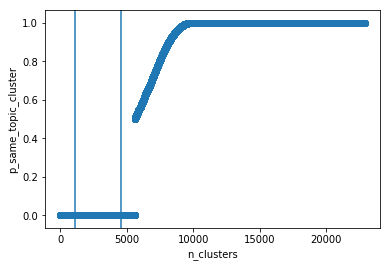

In [174]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [175]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [176]:
n_clusters

5598

In [177]:
subset.loc[:, 'topic_cluster_id'] = gen_clusters(ac_result, n_clusters)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [178]:
topic_cluster_id_counts = subset['topic_cluster_id'].value_counts()

In [179]:
(np.sum(topic_cluster_id_counts.values[topic_cluster_id_counts.values >= 20])
 /np.sum(topic_cluster_id_counts.values))

0.38900782035038667

In [180]:
topic_cluster_id_counts

40028    447
40117    322
38315    299
39000    295
40170    293
39661    199
39928    197
40130    195
40110    193
39919    182
40125    160
40001    144
39988    142
39546    117
39996    116
40066    110
40129    109
38994     91
40090     90
39408     89
38438     87
39847     86
39975     77
38176     75
39770     74
39999     69
39865     66
39929     66
37972     64
38146     64
        ... 
1304       1
3609       1
11805      1
17952      1
22210      1
20305      1
10060      1
1848       1
7963       1
22290      1
18192      1
7947       1
22258      1
16095      1
18128      1
16079      1
7851       1
20017      1
20113      1
1672       1
13950      1
5754       1
3705       1
7787       1
9820       1
22082      1
20033      1
11837      1
1592       1
16         1
Name: topic_cluster_id, Length: 5598, dtype: int64

In [181]:
iterations = 0 
for idx, ct in zip(topic_cluster_id_counts.index, topic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset[
            subset['topic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




447 articles in cluster 40028
HEADLINE: A million march in Hong Kong to protest extradition and eroding freedoms
HEADLINE: A million take to Hong Kong streets to say no to Beijing
HEADLINE: Hundreds of thousands of protesters took to the streets in Hong Kong to express their outrage against a bill that would allow residents to be tried in China
HEADLINE: Hundreds of thousands of protesters took to the streets in Hong Kong to express their outrage against a bill that would allow residents to be tried in China
HEADLINE: Hundreds Of Thousands Of People In Hong Kong Protested Against Sending Crime Suspects To China
HEADLINE: Sea of Protesters Stuns Hong Kong
HEADLINE: Sea of Protesters Stuns Hong Kong
HEADLINE: Hundreds of thousands are protesting an extradition bill in Hong Kong. Here's why.
HEADLINE: Hundreds of thousands are protesting an extradition bill in Hong Kong. Here's why.
HEADLINE: Violence mars end of huge Hong Kong protest against China extradition
HEADLINE: Violence mars 

HEADLINE: Amazon dethrones Google as top global brand: survey | Bangkok Post: news
HEADLINE: Amazon Prime now available in the UAE
HEADLINE: Amazon Prime now available in the UAE
HEADLINE: Amazon dethrones Google as top global brand: survey
HEADLINE: Amazon dethrones Google as top global brand: survey
HEADLINE: Amazon dethrones Google as top global brand: survey
HEADLINE: Amazon dethrones Google as top global brand: survey
HEADLINE: Amazon dethrones Google as top global brand: Survey
HEADLINE: Amazon dethrones Google as top global brand, survey finds
HEADLINE: Amazon dethrones Google as top global brand: survey
HEADLINE: Amazon beats Apple and Google to become the world's most valuable brand
HEADLINE: Amazon dethrones Google as top global brand, survey finds
HEADLINE: International Business: Amazon dethrones Google as top global brand



41 articles in cluster 39652
HEADLINE: Twitter User Who Leaked Most E3 Announcements Says Nintendo's Lawyer Called Them
HEADLINE: Twitter User Who Lea

# Make subtopic cluster classifier

## Output topic clusters to be subtopic clustered

In [64]:
big_clusters = topic_cluster_id_counts[topic_cluster_id_counts.values >= 10].index

In [65]:
len(big_clusters)

400

In [66]:
subset2 = subset[
    subset['topic_cluster_id'].apply(
        lambda x: x in big_clusters
    )
]

In [68]:
subset2.to_csv('../data/subtopic_cluster_training_articles.csv')

## Ingest clustered articles

In [321]:
subtopic_cluster_training_articles_labeled = pd.read_csv('../data/subtopic_cluster_training_articles_labeled.csv')

In [322]:
subtopic_cluster_training_articles_labeled.dropna(subset=['subtopic_cluster_id'], inplace=True)

In [323]:
subtopic_cluster_training_articles_labeled.reset_index(inplace=True)

In [324]:
subtopic_cluster_training_articles_labeled.shape

(2545, 6)

In [325]:
subtopic_cluster_training_articles_labeled.head()

index                       _id  \
0      0  5cffc4659cbe0660ee5577b7   
1      1  5cffaf399cbe0634328357a3   
2      2  5cff594c9cbe067f074e1f10   
3      3  5cff89a89cbe0605d5e430b1   
4      4  5cff39089cbe0675b7392530   

                                               title  topic_cluster_id  \
0  A Guide to the Extradition Law That Has Hong K...             40028   
1  Asian Insider June 11: Why are so many in Hong...             40028   
2                    China’s Power Grab in Hong Kong             40028   
3  Everything you need to know about Hong Kong’s ...             40028   
4  Explainer: Hong Kong's controversial extraditi...             40028   

  subtopic_cluster_id  topic_cluster_size  
0                   1                 447  
1                   1                 447  
2                   1                 447  
3                   1                 447  
4                   1                 447

## Sample pairs

In [332]:
first_ids = []
first_titles = []
second_ids = []
second_titles = []
same_subtopic_clusters = []

for i in tqdm_notebook(range(10000)):
    first_idx = np.random.randint(len(subtopic_cluster_training_articles_labeled))
    first_id = subtopic_cluster_training_articles_labeled._id[first_idx]
    first_title = subtopic_cluster_training_articles_labeled.title[first_idx]
    first_subtopic_cluster_id = subtopic_cluster_training_articles_labeled.subtopic_cluster_id[first_idx]
    
    topic_cluster_id = subtopic_cluster_training_articles_labeled.topic_cluster_id[first_idx]
    
    same_cluster_articles = subtopic_cluster_training_articles_labeled[
        subtopic_cluster_training_articles_labeled.topic_cluster_id == topic_cluster_id 
    ].reset_index()
    second_idx = np.random.randint(len(same_cluster_articles))
    second_id = same_cluster_articles._id[second_idx]
    second_title = same_cluster_articles.title[second_idx]
    second_subtopic_cluster_id = same_cluster_articles.subtopic_cluster_id[second_idx]
    
    first_ids.append(first_id)
    first_titles.append(first_title)
    second_ids.append(second_id)
    second_titles.append(second_title)
    same_subtopic_clusters.append(1 if first_subtopic_cluster_id == second_subtopic_cluster_id else 0)
    

In [333]:
labeled_sc_pairs = pd.DataFrame({
    '_id_0': first_ids,
    'title_0': first_titles,
    '_id_1': second_ids,
    'title_1': second_titles,
    'same_subtopic_cluster': same_subtopic_clusters
})

In [334]:
labeled_sc_pairs.head()

_id_0                     _id_1  same_subtopic_cluster  \
0  5cff1f6a9cbe062797907446  5cfd786a9cbe0650748a2c4a                      0   
1  5cfe1e8b9cbe060a36879c3e  5cfd9e0e9cbe0602be973d6e                      0   
2  5cfdc8d29cbe064f9c1c9226  5cfdd9fe9cbe065e6cf4013e                      1   
3  5cfe1a329cbe0662cba3979a  5cfd7e699cbe067b7a45a5fe                      1   
4  5cfdf5ee9cbe063fbadb4c37  5cfe44849cbe063be25cda71                      0   

                                             title_0  \
0  Warriors' Durant returns, then hobbles out of ...   
1  Nominations set to close in race to be next UK...   
2  Former Red Sox star David Ortiz shot in Domini...   
3  Microsoft gives glimpse of Xbox Scarlett at E3...   
4  Chinese media blames Hong Kong demo on collusi...   

                                             title_1  
0  Durant has chance to play game five says Warri...  
1  Brexit backer Boris Johnson, vying to lead U.K...  
2  David Ortiz shot and wounded in the Dominican ...  
3  New Xbox Project Scarlett coming in 2020, Micr...  
4  Q&A: Why hundreds of thousands protested in Ho...

In [335]:
sum(labeled_sc_pairs.same_subtopic_cluster)

2238

## Calculate metrics for sampled pairs

In [501]:
def selected_subtopic_article_pairs_metrics(df):
    title_dists = np.zeros(len(df))
    text_dists = np.zeros(len(df))
    text_nouns_dists = np.zeros(len(df))
    text_adjs_dists = np.zeros(len(df))
    title_dense_dists = np.zeros(len(df))
    text_dense_dists = np.zeros(len(df))
    time_dists = np.zeros(len(df))

    for idx, row in df.iterrows():
        article_1_idx = recent_content_corpus.df[recent_content_corpus.df._id == row["_id_0"]].index[0]
        article_2_idx = recent_content_corpus.df[recent_content_corpus.df._id == row["_id_1"]].index[0]

        title_dist, text_dist, text_nouns_dist, text_adjs_dist = (
            article_pair_metrics(article_1_idx, article_2_idx)
        )
        
        title_dense_dist = np.round(cosine(
            titles_dense_matrix[article_1_idx],
            titles_dense_matrix[article_2_idx]
        ), 4)
        
        text_dense_dist = np.round(cosine(
            texts_dense_matrix[article_1_idx],
            texts_dense_matrix[article_2_idx]
        ), 4)
        
        time_dist = (
            datetime.strptime(recent_content_corpus.df.crawled_timestamp[article_1_idx][:19], '%Y-%m-%d %H:%M:%S')
            - datetime.strptime(recent_content_corpus.df.crawled_timestamp[article_2_idx][:19], '%Y-%m-%d %H:%M:%S')
        ).total_seconds()
        time_dist = time_dist / 3600 / 24 # convert to days
        time_dist = np.abs(time_dist)

        title_dists[idx] = title_dist
        text_dists[idx] = text_dist
        text_nouns_dists[idx] = text_nouns_dist
        text_adjs_dists[idx] = text_adjs_dist
        title_dense_dists[idx] = title_dense_dist
        text_dense_dists[idx] = text_dense_dist
        
        time_dists[idx] = time_dist

    df['title_dist'] = title_dists
    df['text_dist'] = text_dists
    df['text_nouns_dist'] = text_nouns_dists
    df['text_adjs_dist'] = text_adjs_dists
    df['title_dense_dist'] = title_dense_dists
    df['text_dense_dist'] = text_dense_dists
    df['time_dist'] = time_dists

    return df

In [502]:
%%time
labeled_sc_pairs = selected_subtopic_article_pairs_metrics(labeled_sc_pairs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


CPU times: user 1min 36s, sys: 1.28 s, total: 1min 37s
Wall time: 1min 38s


## Fit classifier

In [682]:
features = ['title_dist', 'text_dist', 'text_nouns_dist', 'text_adjs_dist', 
            'title_dense_dist', 'text_dense_dist']#, 'time_dist']

In [683]:
for feature in features:
    labeled_sc_pairs[feature] = (
        labeled_sc_pairs[feature].apply(lambda x: 1 if np.isnan(x) else x)
    )

Mean precision: 0.7445410713332594


Mean recall: 0.3458501645830742


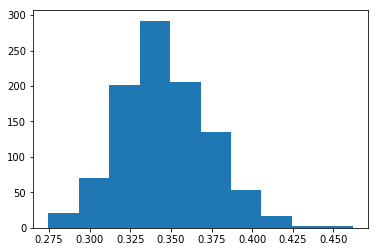

In [684]:
sgds = []
precisions = []
recalls = []
f1s = []
for i in tqdm_notebook(np.arange(1000)):
    X = labeled_sc_pairs[features]
    y = labeled_sc_pairs['same_subtopic_cluster']

    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.5)
    )

    sgd = SGDClassifier(
        loss='log',
        max_iter=100,
        n_jobs=2,
        learning_rate='optimal',
        penalty='l2',
        alpha=0.0001,
        l1_ratio=0.15
    )
    sgd.fit(X_train, y_train)

    pred = sgd.predict(X_test)

    sgds += [sgd]
    precision = metrics.precision_score(y_test, pred)
    precisions += [precision]
    recall = metrics.recall_score(y_test, pred)
    recalls += [metrics.recall_score(y_test, pred)]
    f1 = 2 * precision * recall / (precision + recall)
    f1s += [f1]

print('Mean precision: %s' % str(np.mean(precisions)))
plt.hist(precisions)
plt.show()
print('Mean recall: %s' % str(np.mean(recalls)))
plt.hist(recalls)
plt.show()

In [685]:
f1_max_arg = np.argmax(f1s)

In [686]:
precisions[f1_max_arg]

0.6688311688311688

In [687]:
recalls[f1_max_arg]

0.4618834080717489

In [1312]:
scc = sgds[f1_max_arg]
with open('../models/subtopic_cluster_classifier.pkl', 'wb') as output:
    pickle.dump(scc, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('../models/subtopic_cluster_classifier.pkl', 'rb') as input:
#     scc = pickle.load(input)

In [770]:
scc.coef_

array([[-4.2916557 , -3.81984928,  1.14749902, -0.55034713, -1.72287045,
        -3.62835308]])

In [689]:
labeled_sc_pairs['same_subtopic_cluster_predicted'] = (
    scc.predict(X)
)
labeled_sc_pairs['same_subtopic_cluster_probability'] = (
    scc.predict_proba(X)[:, 1]
)

In [690]:
# false positives
for idx, row in labeled_sc_pairs[
    ((labeled_sc_pairs.same_subtopic_cluster == 0)
     & (labeled_sc_pairs.same_subtopic_cluster_predicted == 1))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])



David Ortiz returns to Boston after being shot in Dominican bar
Former Boston Red Sox star David Ortiz shot at point blank range at bar in Dominican Republic
0.4173
0.4248


Hong Kong To Push Ahead With Extradition Bill That Sparked Huge Protest
Hundreds Of Thousands In Hong Kong Protest Shocking Extradition Bill
0.3395
0.5799


The Latest: Ortiz leaves Dominican Republic on air ambulance
The Latest: Police: David Ortiz shot at Santo Domingo bar
0.1162
0.8104


Why protesters are so outraged about Hong Kong’s new extradition laws
Hong Kong To Push Ahead With Extradition Bill That Sparked Huge Protest
0.2858
0.7106


Hong Kong braces for mass protests over controversial extradition bill
More than 500,000 march in Hong Kong over proposed extradition law
0.2897
0.7138


Former Red Sox slugger David Ortiz wounded in Dominican Republic shooting
Suspect in custody over shooting of retired RedSox slugger David Ortiz
0.3925
0.5442


Five things to know about Hong Kong's extradition law
US wa


Former Red Sox star Ortiz shot in Dominican Republic
Baseball star David Ortiz awake in Boston after surgery for Dominican shooting
0.4001
0.6815


Extradition bill pushes Hong Kong to a political crisis
Hong Kong's last fight is lost
0.2465
0.6837


Why is Hong Kong’s China extradition plan so controversial?
Hundreds of thousands march in Hong Kong to protest China extradition bill
0.458
0.5328


Democrats push ahead with hearings on Russia probe
Democrats push new strategy for enforcing Russia subpoenas
0.3729
0.6015


Extradition bill pushes Hong Kong to a political crisis
Hundreds rally in Hong Kong in fresh protests against extradition bill
0.42
0.6378


Kevin Durant injury: Warriors, Raptors emotional after Finals Game 5
NBA Finals 2019: Will Kevin Durant's return save the Warriors?
0.4565
0.5102


Warriors’ Kevin Durant ‘hurting deep in the soul’ after injuring Achilles in Game 5 of NBA Finals
Kevin Durant Suffered An Achilles Injury In Game 5 Of The NBA Finals
0.597
0.4862


P

In [691]:
# false negatives
for idx, row in labeled_sc_pairs[
    ((labeled_sc_pairs.same_subtopic_cluster == 1)
     & (labeled_sc_pairs.same_subtopic_cluster_predicted == 0))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])



Reports: Former Red Sox star Ortiz shot in leg
David Ortiz reportedly shot in Dominican Republic
0.5414
0.7322


New, faster Xbox coming out next year
Microsoft gives glimpse of new Xbox console
0.3919
0.7515


Donald Trump says he’ll raise China tariffs again if Xi Jinping won’t meet at G20
Donald Trump threatens to unleash new China tariffs if Xi skips G20
0.6584
0.5432


More tariffs on China if Xi skips G20: Trump
Trump defends tariff strategy as China says it's 'not afraid of a trade war'
0.582
0.858


United Technologies and Raytheon are merging in an aerospace mega-deal
Two major U.S. military contractors set to merge - Xinhua
0.5037
1.0


Hong Kong leader refuses to scrap extradition bill despite rally
Hong Kong government to go ahead with extradition bill despite massive protests
0.5578
0.5771


DOJ agrees to share key Mueller report evidence with Congress
Nadler puts Barr contempt push on hold after striking Mueller report deal
0.3527
0.8346


Police: David Ortiz shot in am

0.5989


Ailing ex-Boston slugger David Ortiz on his way to Boston
The Latest: Red Sox offer all resources to Ortiz family
0.3181
0.8984


UK leadership hopefuls launch campaigns to take control of Brexit
Race to replace UK's May gets underway
0.6628
0.8929


Trump ‘concerned’ by Raytheon-United Technologies merger
Trump says United Tech, Raytheon deal may hurt competition
0.5969
0.9344


Microsoft unveils next-gen 'Project Scarlett' Xbox console for release in 2020
Xbox @E3: Halo, Elden Ring and new Xbox console
0.6734
0.7091


Massive protests fail to stop Hong Kong extradition bill
Hong Kong’s Weekend of Rage Puts as Many as a Million in the Streets
0.4333
0.8129


Xbox confirms 'powerful' Project Scarlett console for 2020
New, faster Xbox coming out next year
0.2913
0.8461


Microsoft gives glimpse of Xbox Scarlett at E3 2019
Microsoft unveils next-generation "Project Scarlett" Xbox console for release in 2020
0.4135
0.6396


Ortiz back in Boston for gunshot wound care
David Ortiz 


Trump ready to slap more tariffs on China after G20 meeting
Trump Threatens Tariffs If China's Xi Doesn't Meet With Him
0.6356
0.7083


Why this year's Tony awards lacked that Broadway magic
Who Won ‘Best Musical’ at the 2019 Tony Awards?
0.5311
0.7513


Hong Kong leader refuses to scrap extradition bill despite rally
The Latest: Hong Kong sets June 20 vote on contentious bill
0.6258
0.8182


Hong Kong leader Carrie Lam defiant as city gears up for fresh protests, strikes
Hong Kong to push ahead with bill that sparked huge protest
0.5575
0.8579


Hong Kong to push ahead with bill that sparked huge protest
Hong Kong pushes bill allowing extraditions to China despite biggest protest since handover
0.3161
0.7482


House set to empower committees to sue Trump over subpoenas
House to vote on taking its subpoenas to court
0.5045
0.6628


Trump ready to slap more tariffs on China after G20 meeting
Trump says tariffs on remaining Chinese goods set to come into force - CityAM
0.5277
0.8449


H

0.6399
1.0


‘Hadestown’ leads awards, nets rare female director trophy
Hadestown' Is Big Winner At 2019 Tony Awards With 8 Trophies
0.5827
0.7594


Hong Kong protesters want to derail extradition bill
Protests flood Hong Kong's streets over extradition law
0.6008
0.6749


House Democrats make deal to see Mueller files on Trump
Justice Department to provide Mueller evidence to Congress: Nadler
0.5281
0.8549


Hong Kong leader says extradition bill will not be scrapped
Hong Kong presses ahead with extradition bill despite protests
0.628
0.6375


Hong Kong protests | Carter talks Trump: WATCH the top World news videos for today
Extradition bill pushes Hong Kong to a political crisis
0.6652
0.8112


Trump ready to slap more tariffs on China after G20 meeting
Trump takes hard line on new China tariff threat if Xi proves a no-show
0.4286
0.887


China telecom giant Huawei hints US pressure hurting sales
Huawei executive says goal to be world's top phone maker some time off
0.5336
0.8935


T

E3: Xbox One successor Project Scarlett will launch in 2020 - here's everything you need to know
0.582
0.8749


Watergate figure John Dean front-and-center as Dems prepare hearings on obstruction, collusion claims
Star Watergate witness calls Mueller report a 'road map' for investigating Trump
0.358
0.8956


Tony Awards 2019: The good (James Corden), bad (riding King Kong) and ugly (cutting off Andre De Shields and Ali Stroker)
2019 Tony Awards Recap: Best, Weirdest and Wildest Moments
0.569
0.8066


Tony Awards offered little surprise, a lackluster James Corden
2019 Tony Awards: ‘Hadestown,’ ‘The Ferryman’ lead early winners [UPDATING LIVE]
0.7523
0.846


International Business: Trump ready to slap more tariffs on China after G20 meeting
Trump levels new tariff threat against China if Xi doesn't meet him
0.6242
0.8778


Trump says U.S. will release additional details on deal with Mexico - Xinhua
Trump promises more 'to be revealed' in U.S.-Mexico deal
0.5367
0.8197


Huawei concedes i

Hadestown,' Cranston win big at Tonys, 'Ferryman' best play
0.4005
0.922


Trump insists there’s more to Mexico deal than meets the eye
Trump defends deal with Mexico that critics say will do little to curb migrant crisis
0.396
0.7743


Microsoft details 'Project Scarlett' Xbox, cloud streaming service
Xbox Scarlett: Microsoft reveals new Xbox will be four times more powerful
0.5121
0.573


Hong Kong leader defiant as city gears up for fresh protests over extradition bill
Hong Kong vows to press ahead with extradition bill despite huge protest
0.4172
0.7456


Beating Boris Johnson: Race to replace UK's Theresa May kicks off
PICS: These are the Conservative Party candidates vying to succeed Theresa May
0.4942
0.8469


HK protest blamed on collusion with West - Asean+
China backs Hong Kong extradition law, opposes 'foreign interference'
0.6176
1.0


White House official seeks to delay us law targeting Huawei
The White House needs to clarify its position on Huawei after Trump and Mnuchin 

United Technologies Is Making an Odd Takeover Offer for Raytheon
UTC-Raytheon merger in investors' sights
0.6991
1.0


Two major U.S. military contractors set to merge - Xinhua
Raytheon and United Technologies announce merger
0.6086
1.0


Police: David Ortiz shot in ambush at Santo Domingo bar
David Ortiz, baseball legend, shot at Dominican Republic bar
0.6215
0.5958


Hong Kong leader refuses to scrap extradition bill despite huge protest
Hong Kong's Leader Says Extradition Bill to Go Ahead Prompting Calls for Fresh Protests
0.4484
0.6681


Durant's return for Warriors in NBA Finals was a short one
WATCH: Durant's shock injury exit stuns NBA Finals rivals
0.4807
0.6646


Beijing Is Obeyed: Hong Kong to Push Ahead with China Extradition Bill
HK leader refuses to scrap extradition Bill - Asean+
0.48
0.8852


Hong Kong Chief vows to hold firm on extraditions
Hong Kong leader says extradition bill will not be scrapped
0.4563
0.7771


House Democrats to get more Mueller evidence, Trump cal

# Supervised topic clustering

## Generate same_subtopic_cluster_probs graph

In [584]:
from sklearn.metrics.pairwise import euclidean_distances

In [692]:
crawled_epochs = recent_content_corpus.df.crawled_timestamp.apply(
    lambda x: datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S').timestamp() / 3600 / 24
).reshape(-1, 1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [693]:
def get_same_subtopic_cluster_probs(subset, pairs_dists_max_memory_use_mb=500):
    n_articles = len(subset)
    subset_indices = subset.index.values
    
    same_subtopic_cluster_probs = lil_matrix((n_articles, n_articles))
    num_dist_matrices = 6
    per_dist_matrix_max_memory = pairs_dists_max_memory_use_mb / num_dist_matrices / 2
    cols_batch = int(min(n_articles, per_dist_matrix_max_memory/8e-6))
    rows_batch = int(min(n_articles, per_dist_matrix_max_memory/(cols_batch * 8e-6)))

    # slice first articles
    for start_row in np.arange(0, n_articles, rows_batch):
        end_row = min(start_row+rows_batch, n_articles)

        # get first articles' vectors
        first_article_indices = subset_indices[start_row:end_row]
        first_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[first_article_indices]
        first_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[first_article_indices]
        first_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[first_article_indices]
        first_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[first_article_indices]
        first_titles_dense_matrix = titles_dense_matrix[first_article_indices]
        first_texts_dense_matrix = texts_dense_matrix[first_article_indices] 
        first_crawled_epochs = crawled_epochs[first_article_indices]

        # slice second articles
        for start_col in np.arange(start_row, n_articles, cols_batch):
            end_col = min(start_col+cols_batch, n_articles)

            # get second articles' vectors
            second_article_indices = subset_indices[start_col:end_col]    
            second_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[second_article_indices]
            second_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[second_article_indices]
            second_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[second_article_indices]
            second_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[second_article_indices]
            second_titles_dense_matrix = titles_dense_matrix[second_article_indices]
            second_texts_dense_matrix = texts_dense_matrix[second_article_indices]
            second_crawled_epochs = crawled_epochs[second_article_indices]

            # create article pairs distance matrices
            titles_dists = 1-cosine_similarity(first_titles_tfidf_matrix, second_titles_tfidf_matrix)
            texts_dists = 1-cosine_similarity(first_texts_tfidf_matrix, second_texts_tfidf_matrix)
            nouns_dists = 1-cosine_similarity(first_nouns_tfidf_matrix, second_nouns_tfidf_matrix)
            adjs_dists = 1-cosine_similarity(first_adjs_tfidf_matrix, second_adjs_tfidf_matrix)
            titles_dense_dists = 1-cosine_similarity(first_titles_dense_matrix, second_titles_dense_matrix)
            texts_dense_dists = 1-cosine_similarity(first_texts_dense_matrix, second_texts_dense_matrix)
            time_dists = euclidean_distances(first_crawled_epochs, second_crawled_epochs)
            
            # conserve memory
            del second_article_indices, second_titles_tfidf_matrix, second_texts_tfidf_matrix,\
                second_nouns_tfidf_matrix, second_adjs_tfidf_matrix, first_titles_dense_matrix,\
                first_texts_dense_matrix, second_titles_dense_matrix, second_texts_dense_matrix, \
                first_crawled_epochs, second_crawled_epochs
            
            # combine article pairs distances
            pairs_metrics = pd.merge(
                subset[['const', 'n']][start_row:end_row], 
                subset[['const', 'n']][start_col:end_col], 
                on='const'
            )
            pairs_metrics['title_dist'] = titles_dists.reshape(-1)
            pairs_metrics['text_dist'] = texts_dists.reshape(-1)
            pairs_metrics['text_nouns_dist'] = nouns_dists.reshape(-1)
            pairs_metrics['text_adjs_dist'] = adjs_dists.reshape(-1)
            pairs_metrics['title_dense_dist'] = titles_dense_dists.reshape(-1)
            pairs_metrics['text_dense_dist'] = texts_dense_dists.reshape(-1)
            pairs_metrics['time_dist'] = time_dists.reshape(-1)
            
            # conserve memory
            del titles_dists, texts_dists, nouns_dists, adjs_dists, titles_dense_dists,\
                texts_dense_dists, time_dists

            # estimate p(same_cluster)
            pairs_metrics['same_subtopic_cluster_probability'] = (
                scc.predict_proba(pairs_metrics[features])[:, 1]
            )
            
            pairs_metrics = pairs_metrics[
                pairs_metrics['same_subtopic_cluster_probability'] > 0
            ]
            
            for x, y, p in zip(pairs_metrics['n_x'],
                               pairs_metrics['n_y'],
                               pairs_metrics['same_subtopic_cluster_probability']):
                same_subtopic_cluster_probs[x, y] = same_subtopic_cluster_probs[y, x] = p
    
    return same_subtopic_cluster_probs

## Cluster same_subtopic_cluster_probs graph

In [1270]:
subset2 = subset[
    subset.topic_cluster_id == topic_cluster_id_counts.index[14]
]

subset2.loc[:, 'const'] = np.zeros(len(subset2))
subset2.loc[:, 'n'] = np.arange(len(subset2))
subset2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


_id           crawled_timestamp  \
200    5cfd649f9cbe063836d5c6b0  2019-06-09 19:57:19.960920   
1009   5cfd78cf9cbe06570f7ff8c4  2019-06-09 21:23:27.433812   
1019   5cfd79219cbe065a4482e653  2019-06-09 21:24:49.263185   
1020   5cfd79239cbe065a5be5b5ad  2019-06-09 21:24:51.508260   
1072   5cfd79949cbe065fc3b84bc3  2019-06-09 21:26:43.493073   
1073   5cfd79949cbe065fc3b84bc4  2019-06-09 21:26:44.454631   
1128   5cfd7a6e9cbe066afc0f7b7d  2019-06-09 21:30:22.379363   
1264   5cfd7abe9cbe066d9016b746  2019-06-09 21:31:42.292615   
1269   5cfd7af19cbe0670bf17c83a  2019-06-09 21:32:32.948938   
1271   5cfd7af39cbe0670d0fc19b7  2019-06-09 21:32:34.850764   
1445   5cfd802c9cbe0613e361e6c3  2019-06-09 21:54:52.494503   
1559   5cfd81b69cbe06273908721e  2019-06-09 22:01:26.113723   
1657   5cfd84fe9cbe062ddc366092  2019-06-09 22:15:26.764074   
1658   5cfd85009cbe062ddc366093  2019-06-09 22:15:28.618895   
1673   5cfd853b9cbe063116be8046  2019-06-09 22:16:27.804720   
1937   5cfd88a39cbe065ed7806f88  2019-06-09 22:30:59.079742   
1978   5cfd8bf69cbe0665894d9449  2019-06-09 22:45:10.008296   
2037   5cfd8c7a9cbe066c3573843d  2019-06-09 22:47:22.793801   
2111   5cfd8e429cbe0605761ca78e  2019-06-09 22:54:57.936532   
2114   5cfd8e449cbe06058bdc19d8  2019-06-09 22:55:00.245537   
2119   5cfd8e4a9cbe0605d46d4aad  2019-06-09 22:55:06.356084   
2123   5cfd8e609cbe06073bfd4155  2019-06-09 22:55:28.057562   
2223   5cfd90139cbe06195d035c91  2019-06-09 23:02:42.678269   
2283   5cfd933d9cbe0621e5188ada  2019-06-09 23:16:13.578045   
2402   5cfd94939cbe0632ee8d914e  2019-06-09 23:21:54.575050   
2403   5cfd94939cbe0632f10d0c11  2019-06-09 23:21:55.538403   
2576   5cfd96959cbe064e6a4f2bf4  2019-06-09 23:30:29.976744   
2946   5cfd9ab99cbe06594003348b  2019-06-09 23:48:09.958739   
2950   5cfd9abf9cbe065fac3ad02f  2019-06-09 23:48:14.758282   
3049   5cfd9cd49cbe0675c74303af  2019-06-09 23:57:08.576715   
...                         ...                         ...   
18359  5cfe7fa49cbe0614df5fa14d  2019-06-10 16:04:52.528341   
19195  5cfe87439cbe0652961d7364  2019-06-10 16:37:23.133283   
19197  5cfe87449cbe0652961d7366  2019-06-10 16:37:24.350994   
19432  5cfe8a249cbe06682817c0a3  2019-06-10 16:49:40.295457   
19472  5cfe8a619cbe066a2dcd65fd  2019-06-10 16:50:41.449283   
20144  5cfe913f9cbe0624a322337c  2019-06-10 17:19:59.435479   
20202  5cfe91ab9cbe06287902f148  2019-06-10 17:21:47.648826   
20554  5cfe95a19cbe06497c7146ae  2019-06-10 17:38:41.124377   
20689  5cfe97919cbe0659477adac9  2019-06-10 17:46:56.965914   
20756  5cfe981e9cbe065efd8e2772  2019-06-10 17:49:18.034104   
20864  5cfe995c9cbe0667f225deb7  2019-06-10 17:54:36.827857   
20955  5cfe9a809cbe06740eec60bc  2019-06-10 17:59:28.633244   
20982  5cfe9afd9cbe0677455932d2  2019-06-10 18:01:33.463712   
20986  5cfe9b009cbe0677688accde  2019-06-10 18:01:36.238469   
21161  5cfe9d639cbe060bea2c278a  2019-06-10 18:11:47.509076   
21274  5cfe9e7b9cbe0613f5e57b6a  2019-06-10 18:16:27.549880   
21509  5cfea0c49cbe06283d737dd2  2019-06-10 18:26:12.959888   
21693  5cfea39a9cbe0641c4f49b9f  2019-06-10 18:38:18.143637   
22068  5cfea8da9cbe066912c8e933  2019-06-10 19:00:42.556877   
22071  5cfea8de9cbe06693a34edfc  2019-06-10 19:00:46.217666   
22314  5cfeac889cbe06059f68eedc  2019-06-10 19:16:24.943164   
22577  5cfeaffd9cbe0622b5389818  2019-06-10 19:31:09.055470   
24136  5cfec6aa9cbe065dd65efc93  2019-06-10 21:07:54.121588   
24382  5cfec9299cbe066e337fd987  2019-06-10 21:18:33.476167   
24491  5cfecacd9cbe067cadfb88e9  2019-06-10 21:25:33.272143   
25055  5cfed1ce9cbe06353c137160  2019-06-10 21:55:26.233817   
25525  5cfed8889cbe066a8ea334f4  2019-06-10 22:24:08.408138   
28016  5cff00d69cbe0630002d72f2  2019-06-11 01:16:06.286089   
39805  5cffa8d79cbe067ce6f90965  2019-06-11 13:12:55.888866   
46059  5cffe7269cbe067827384c30  2019-06-11 17:38:45.812334   

                                           meta_keywords  \
200    international business United Technologies U.S...   
1

In [1271]:
sys.getsizeof(subset2)/1e6

0.715812

In [1272]:
n_articles = len(subset2)
print(n_articles)

116


In [1299]:
%%time
X = -get_same_subtopic_cluster_probs(subset2).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.4
# ^ somewhere between 0.33 and 0.5 appears to work best
# specifically, 0.4: https://docs.google.com/spreadsheets/d/1s4_zE4ayaYhDc_sDdPHNpXx0-D0EQ-ofYmI4YeZrFPQ/edit#gid=66843440

CPU times: user 418 ms, sys: 48.1 ms, total: 466 ms
Wall time: 146 ms


In [1300]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

CPU times: user 71.2 ms, sys: 1.87 ms, total: 73.1 ms
Wall time: 72.1 ms


In [1301]:
ac_result.shape

(91, 3)

In [1302]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [1303]:
ac_result_dec = ac_result[::-1] # easier to work with

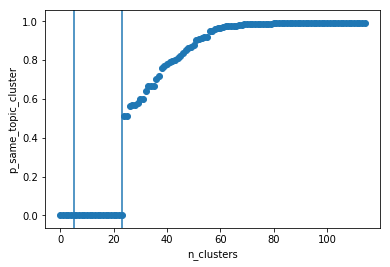

In [1304]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [1305]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [1306]:
n_clusters

25

In [1307]:
subset2.loc[:, 'subtopic_cluster_id'] = gen_clusters(ac_result, n_clusters)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [1308]:
subtopic_cluster_id_counts = subset2['subtopic_cluster_id'].value_counts()

In [1309]:
(np.sum(subtopic_cluster_id_counts.values[subtopic_cluster_id_counts.values >= 10])
 /np.sum(subtopic_cluster_id_counts.values))

0.6120689655172413

In [1310]:
subtopic_cluster_id_counts

205    50
206    21
191     8
200     4
118     3
153     3
195     3
161     2
166     2
169     2
201     2
164     2
151     2
115     1
100     1
101     1
109     1
55      1
42      1
110     1
112     1
36      1
113     1
26      1
114     1
Name: subtopic_cluster_id, dtype: int64

In [1311]:
iterations = 0 
for idx, ct in zip(subtopic_cluster_id_counts.index, subtopic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset2[
            subset2['subtopic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




50 articles in cluster 205
HEADLINE: Two top U.S. tech firms plan to merge aerospace arms to create aviation giant, source says
HEADLINE: Raytheon, United Technologies merge into $74 billion aerospace giant
HEADLINE: Raytheon, United Technologies merge into $74 billion aerospace giant
HEADLINE: Raytheon, United Technologies merge into $74 billion aerospace giant
HEADLINE: Raytheon, United Technologies agree to blockbuster defense deal
HEADLINE: Raytheon, United Technologies agree to blockbuster defense deal
HEADLINE: United Technologies 'in talks to merge with US arms giant'
HEADLINE: United Technologies and Raytheon agree to merge
HEADLINE: United Technologies and Raytheon agree to merge
HEADLINE: Raytheon, United Technologies merge into $74 billion aerospace giant
HEADLINE: Raytheon, United Technologies to merge
HEADLINE: Raytheon, United Technologies to merge
HEADLINE: United Technologies to merge aerospace business with Raytheon
HEADLINE: United Technologies to merge aerospace b